In [1]:
import sys
sys.path.append("D:/Notebooks/modules")
from utils import scantree
from utils_3d import show_slices_gif_tensor, show_slices_gif_paths, rotate_3d_tensor, plot_3d_volume_mayavi, TensorPathsDataset, get_front_view, get_front_views
from transforms import Rotate3d
from CTKidney_models import MVCNN
from torch import nn
import torchinfo

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


d:\ProgramFiles\anaconda3\envs\pytorch_env\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
d:\ProgramFiles\anaconda3\envs\pytorch_env\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [2]:
config = {
    'input_shape': (30, 128, 128),
    'batch_size': 64,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'n_epochs': 200,
    'seed': 0,
    'get_front_view_thresh': 0.15
}

152 21
torch.Size([64, 30, 128, 128]) torch.Size([64])
tensor(0.) tensor(1.) tensor([0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 3, 1, 0, 3, 1, 0, 3, 2, 2, 2, 0, 0, 2, 1,
        1, 1, 3, 2, 3, 2, 0, 1, 0, 2, 2, 0, 2, 0, 2, 1, 0, 3, 0, 3, 1, 1, 2, 1,
        2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 3, 0])


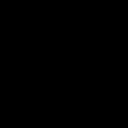

In [3]:
train_dataset = TensorPathsDataset(r'D:\Notebooks\Kidney CT\augmented_volumes\Rotate3d_AllAxes_-30to30_RandomFlip3d\Train', 20, 'train')
valid_dataset = TensorPathsDataset(r'D:\Notebooks\Kidney CT\augmented_volumes\Rotate3d_AllAxes_-30to30_RandomFlip3d\Valid', 20, 'valid')

print(len(train_dataset), len(valid_dataset))

train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle= True)
valid_loader = DataLoader(valid_dataset, batch_size = config['batch_size'])

volumes, labels = next(iter(train_loader))
print(volumes.shape, labels.shape)
print(volumes.min(), volumes.max(), labels)

show_slices_gif_tensor(volumes[0])
# plot_3d_volume_mayavi(volumes[0])

torch.Size([30, 128, 128]) tensor(0.) tensor(1.)


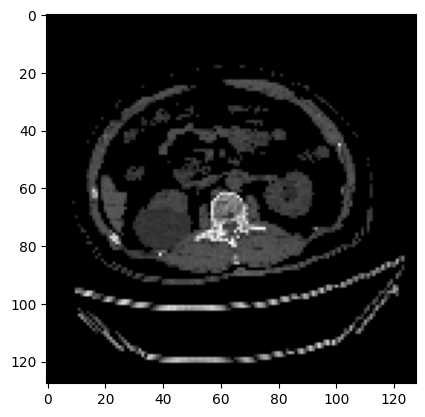

In [4]:
# To Do: Get the rotated 3d volume and the front view from the original CT before resizing this
volume = volumes[0]
print(volume.shape, volume.min(), volume.max())
view = get_front_view(volume, 0.15)
plt.imshow(view, 'gray')


In [5]:
model = MVCNN(r"D:\Checkpoints\ImageNet checkpoints\alexnet-owt-7be5be79.pth")
model.to(config['device'])

torchinfo.summary(model, input_size = (1, 3, 227, 227), col_names = ["kernel_size", "output_size", "num_params", "trainable"])

d:\Notebooks\Kidney CT\CTKidney_models.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.alexnet.load_state_dict(torch.load(checkpoint_path))


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #                   Trainable
MVCNN                                    --                        [1, 4]                    --                        Partial
├─AlexNet: 1-1                           --                        [1, 4]                    --                        Partial
│    └─Sequential: 2-1                   --                        [1, 256, 6, 6]            --                        False
│    │    └─Conv2d: 3-1                  [11, 11]                  [1, 64, 56, 56]           (23,296)                  False
│    │    └─ReLU: 3-2                    --                        [1, 64, 56, 56]           --                        --
│    │    └─MaxPool2d: 3-3               3                         [1, 64, 27, 27]           --                        --
│    │    └─Conv2d: 3-4                  [5, 5]                    [1, 192, 27, 27]          (307,392)                 Fals

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay=0.001, momentum= 0.9)
loss_fn = nn.CrossEntropyLoss()

def get_accuracy(logits, targets):
    preds = torch.argmax(logits, dim = 1)
    return torch.sum(preds == targets).item() / len(preds)

In [7]:
train_losses = []
valid_losses = []

best_acc, best_loss = 0, 100

for epoch in range(config['n_epochs']):
    train_loss = 0
    valid_loss = 0
    
    train_acc = 0
    valid_acc = 0
    
    model.train()
    
    for volumes, labels in train_loader:
        # Get the front view of each volume
        images = get_front_views(volumes, config['get_front_view_thresh'])
        images, labels = images.to(config['device']), labels.to(config['device'])
        
        logits = model(images)
        loss = loss_fn(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().cpu().item()
        train_acc += get_accuracy(logits, labels)
        
    model.eval()
    
    with torch.inference_mode():
        for batch, labels in valid_loader:
            labels = labels.to(config['device'])
            logits_list = []

            for volumes in batch:
                images = get_front_views(volumes, config['get_front_view_thresh'])
                images = images.to(config['device'])
                
                logits = model.forward_multi_view(images)
                logits_list.append(logits.squeeze())

            logits_list = torch.stack(logits_list)
            loss = loss_fn(logits_list, labels)
            valid_loss += loss.detach().cpu().item()
            valid_acc += get_accuracy(logits_list, labels)

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    train_acc /= len(train_loader)
    valid_acc /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if epoch % 1 == 0:
        print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Acc: {valid_acc:.4f}")

    # Save the model with highest accuracy
    if epoch > 10 and ((valid_acc > best_acc) or (valid_acc == best_acc and valid_loss < best_loss)):
        best_acc, best_loss = valid_acc, valid_loss
        torch.save(model.state_dict(), "MV-CNN.pt")
        print("Checkpoint was saved!")


print(f"Best validation accuracy: {best_acc:.4f}")



Epoch: 1 | Train Loss: 1.4946 | Valid Loss: 1.4044 | Train Acc: 0.3819 | Valid Acc: 0.4762
Epoch: 2 | Train Loss: 1.2154 | Valid Loss: 2.2188 | Train Acc: 0.4740 | Valid Acc: 0.4286
Epoch: 3 | Train Loss: 1.3072 | Valid Loss: 1.6359 | Train Acc: 0.5000 | Valid Acc: 0.5238
Epoch: 4 | Train Loss: 1.2074 | Valid Loss: 1.1858 | Train Acc: 0.5035 | Valid Acc: 0.5714
Epoch: 5 | Train Loss: 1.1958 | Valid Loss: 2.0242 | Train Acc: 0.5000 | Valid Acc: 0.6667
Epoch: 6 | Train Loss: 1.1317 | Valid Loss: 1.3942 | Train Acc: 0.5608 | Valid Acc: 0.3333
Epoch: 7 | Train Loss: 1.1778 | Valid Loss: 1.9493 | Train Acc: 0.5035 | Valid Acc: 0.6667
Epoch: 8 | Train Loss: 1.2359 | Valid Loss: 1.8721 | Train Acc: 0.5694 | Valid Acc: 0.5238
Epoch: 9 | Train Loss: 0.9752 | Valid Loss: 1.5567 | Train Acc: 0.5851 | Valid Acc: 0.5714
Epoch: 10 | Train Loss: 1.0050 | Valid Loss: 1.6163 | Train Acc: 0.5208 | Valid Acc: 0.4762
Epoch: 11 | Train Loss: 1.1661 | Valid Loss: 1.5166 | Train Acc: 0.5660 | Valid Acc: 0.61

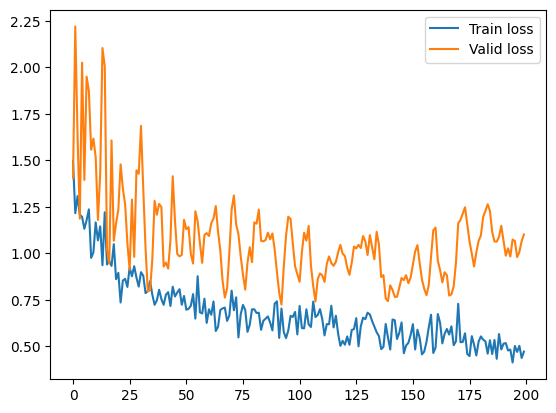

In [9]:
plt.plot(range(len(train_losses)), train_losses, label = 'Train loss')
plt.plot(range(len(valid_losses)), valid_losses, label = 'Valid loss')
plt.legend()